In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model

np.random.seed(42)
tf.random.set_seed(42)

2024-05-06 11:25:48.291924: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
#For inline plotting 
%matplotlib inline                 
%config InlineBackend.figure_format = 'svg'

plt.style.use("seaborn-v0_8-dark")  

In [2]:
from sklearn.metrics import mean_absolute_percentage_error

In [3]:
# get data 

!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

--2024-05-06 11:32:28--  https://lazyprogrammer.me/course_files/airline_passengers.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2036 (2.0K) [text/csv]
Saving to: 'airline_passengers.csv'

airline_passengers. 100%[===================>]   1.99K  --.-KB/s    in 0s      

2024-05-06 11:32:29 (4.35 MB/s) - 'airline_passengers.csv' saved [2036/2036]



### ANN for Time-Series Forecasting: Airline Passenger Data
----------


We will build a simple Neural Network to predict airline passenger data using 3 different supervised methods:

1. Supervised one step forecast 
2. Incremental, multi-step forecast
3. Multi-output, multi-step forecasting

In [4]:
df = pd.read_csv('airline_passengers.csv', index_col=0, parse_dates = True)

In [5]:
df['LogPassengers']=np.log(df['Passengers'])

In [6]:
df.head()

,Passengers,LogPassengers
Month,,
1949-01-01,112,4.718499
1949-02-01,118,4.770685
1949-03-01,132,4.882802
1949-04-01,129,4.859812
1949-05-01,121,4.795791


In [7]:
# train-test split 

Ntest = 12
train, test = df.iloc[:-Ntest], df.iloc[-Ntest:]

train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]


In [9]:
# differenced Log passegers 

df['DiffLogPassengers'] = df['LogPassengers'].diff()

df.head()

,Passengers,LogPassengers,DiffLogPassengers
Month,,,
1949-01-01,112,4.718499,NaN
1949-02-01,118,4.770685,0.052186
1949-03-01,132,4.882802,0.112117
1949-04-01,129,4.859812,-0.022990
1949-05-01,121,4.795791,-0.064022


In [11]:
# Prepare a supervised data set using T last vals to predict the next 

series = df['DiffLogPassengers'].dropna().to_numpy()

T = 10 
X = []
Y = []

for t in range(len(series)-T):

    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X)
Y = np.array(Y)
N = len(X)

print(f'Shape of X: {X.shape}', f'Shape of Y:{Y.shape}')

Shape of X: (133, 10) Shape of Y:(133,)


In [13]:
# Test and train split for the supervised data set X and Y 

X_train, y_train = X[:-Ntest], Y[:-Ntest]
X_test, y_test = X[-Ntest:], Y[-Ntest:]

In [14]:
# Simple ANN

i = Input(shape = (T,))
x = Dense(32, activation = 'relu')(i)
x = Dense(1)(x)
model = Model(i,x)

In [15]:
model.compile(loss = 'mse', optimizer = 'adam', metrics = 'mae')

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense (Dense)               (None, 32)                352       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 385 (1.50 KB)
Trainable params: 385 (1.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
result = model.fit(X_train, y_train, epochs = 100, validation_data = (X_test, y_test))

Epoch 1/100
4/4 [==============================] - 1s 62ms/step - loss: 0.0109 - mae: 0.0904 - val_loss: 0.0121 - val_mae: 0.1004
Epoch 2/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0102 - mae: 0.0873 - val_loss: 0.0115 - val_mae: 0.0970
Epoch 3/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0095 - mae: 0.0841 - val_loss: 0.0109 - val_mae: 0.0942
Epoch 4/100
4/4 [==============================] - 0s 24ms/step - loss: 0.0089 - mae: 0.0811 - val_loss: 0.0103 - val_mae: 0.0914
Epoch 5/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0084 - mae: 0.0785 - val_loss: 0.0098 - val_mae: 0.0885
Epoch 6/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0078 - mae: 0.0758 - val_loss: 0.0093 - val_mae: 0.0859
Epoch 7/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0073 - mae: 0.0732 - val_loss: 0.0089 - val_mae: 0.0836
Epoch 8/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0069 - mae: 0.07

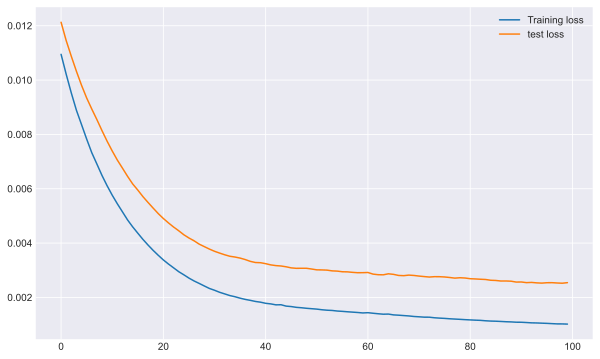

In [20]:
fig, axes = plt.subplots(figsize = (10,6))

axes.plot(result.history['loss'], label = 'Training loss')
axes.plot(result.history['val_loss'], label = 'test loss')

axes.grid()
axes.legend()

In [21]:
# First T+1 values are not predictable since we differenced the Log Passenger data 

train_idx[:T+1] = False

In [22]:
# get training and test predictions and store them

pred_train = model.predict(X_train).flatten()
pred_test = model.predict(X_test).flatten()

df.loc[train_idx, 'ANN_train_p'] = pred_train
df.loc[test_idx, 'ANN_test_p'] = pred_test

1/1 [==============================] - 0s 24ms/step


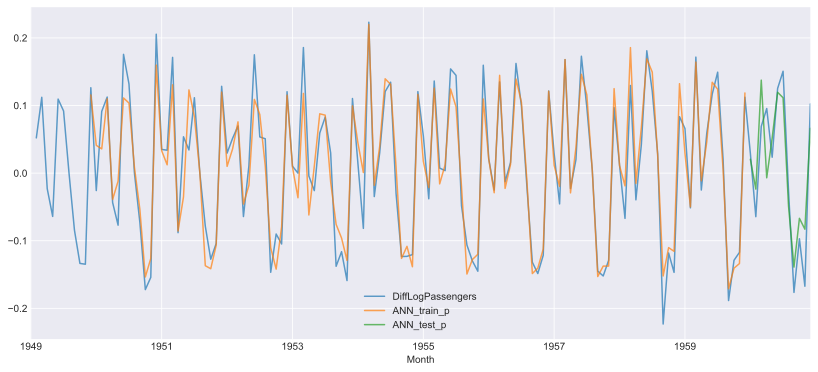

In [25]:
# Plot predictions vs data 

fig, axes = plt.subplots(figsize = (14,6))

p_cols = df.columns.to_list()

df[p_cols[-3:]].plot(ax = axes, alpha = 0.7)

axes.grid()



In [32]:
df.head(12)

,Passengers,LogPassengers,DiffLogPassengers,ANN_train_p,ANN_test_p,LogPassengers_Shifted
Month,,,,,,
1949-01-01,112,4.718499,NaN,NaN,NaN,NaN
1949-02-01,118,4.770685,0.052186,NaN,NaN,4.718499
1949-03-01,132,4.882802,0.112117,NaN,NaN,4.770685
1949-04-01,129,4.859812,-0.022990,NaN,NaN,4.882802
1949-05-01,121,4.795791,-0.064022,NaN,NaN,4.859812
1949-06-01,135,4.905275,0.109484,NaN,NaN,4.795791
1949-07-01,148,4.997212,0.091937,NaN,NaN,4.905275
1949-08-01,148,4.997212,0.000000,NaN,NaN,4.997212
1949-09-01,136,4.912655,-0.084557,NaN,NaN,4.997212


In [29]:
# Compute the un-differenced predictions 

df['LogPassengers_Shifted'] = df['LogPassengers'].shift(1)

prev = df['LogPassengers_Shifted']

In [30]:
# Last known train value 

last_train = train.iloc[-1]['LogPassengers']

In [33]:
# 1 - step forecast, recall that we modified train_idx setting first T+1 vals to False

df.loc[train_idx, '1s_train_pred'] = prev[train_idx] + pred_train

df.loc[test_idx, '1s_test_pred'] = prev[test_idx] + pred_test

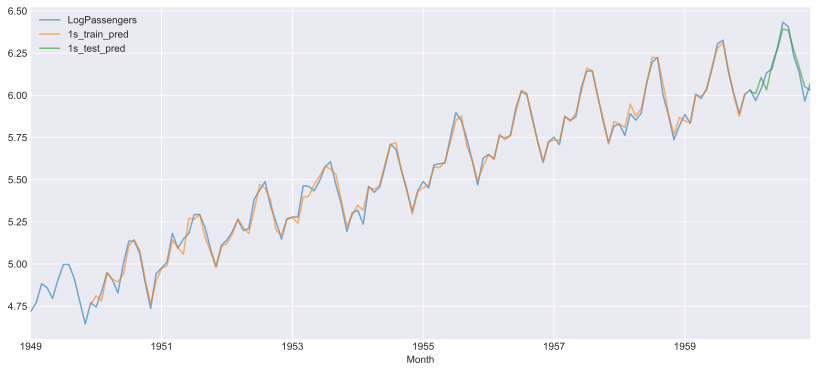

In [34]:
# Plot actual predictions 

fig, axes = plt.subplots(figsize = (14,6))

cols = ['LogPassengers', '1s_train_pred', '1s_test_pred']

df[cols].plot(ax= axes, alpha = 0.6)

axes.grid()

In [40]:
# multi-step incremental forecast 

ms_preds = []

# first test input 

last_x = X_test[0]

while len(ms_preds)< Ntest:
    
    pred = model.predict(last_x.reshape(1,-1))[0]

    # update the predictions list 

    ms_preds.append(pred)

    # make the new input 

    last_x = np.roll(last_x, -1)
    last_x[-1] = pred



1/1 [==============================] - 0s 21ms/step


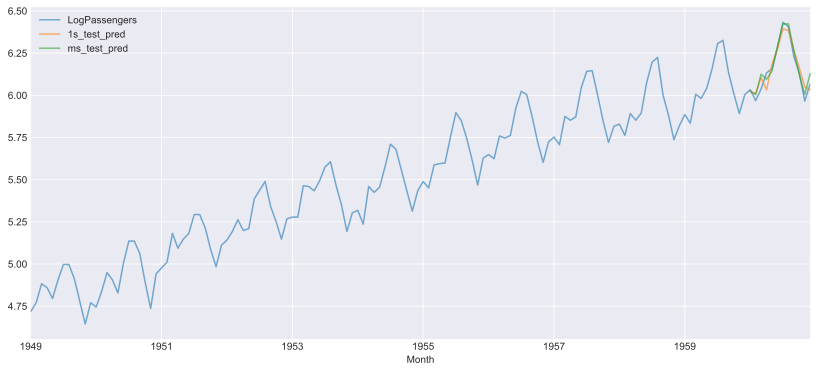

In [47]:
# save multi-step forecast to df and plot with respect to 1-step test forecasts 

df.loc[test_idx, 'ms_test_pred'] = last_train + np.cumsum(ms_preds)

fig, axes = plt.subplots(figsize = (14,6))

df[['LogPassengers', '1s_test_pred', 'ms_test_pred']].plot(ax = axes, alpha = 0.6)

axes.grid()

Multistep forecast looks pretty good, at least as good as the 1-step or even better to capture the peaks 

In [48]:
# Prepare multi-output supervised dataset 

Tx = T
Ty = Ntest

X = []
Y = []

for t in range(len(series)- Tx- Ty + 1):

    x = series[t:t + Tx]
    X.append(x)

    y = series[t+Tx:t+Tx+Ty]
    Y.append(y)


X = np.array(X)
Y = np.array(Y)
N = len(X)

print(f'X shape: {X.shape}', f'Y shape: {Y.shape}')

X shape: (122, 10) Y shape: (122, 12)


In [60]:
# train- test split 

X_train_m, y_train_m  = X[:-1], Y[:-1]

X_test_m, y_test_m = X[-1:], Y[-1:] # last entry in the X and Y will be the test set

In [61]:
# Simple ANN

i = Input(shape = (Tx,))
x = Dense(32, activation = 'relu')(i)
x = Dense(Ty)(x)

mo_model = Model(i,x)

mo_model.compile(loss = 'mse', optimizer = 'adam')

mo_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_6 (Dense)             (None, 32)                352       
                                                                 
 dense_7 (Dense)             (None, 12)                396       
                                                                 
Total params: 748 (2.92 KB)
Trainable params: 748 (2.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [62]:
result_mo = mo_model.fit(X_train_m, y_train_m, epochs = 100, validation_data=(X_test_m, y_test_m))

Epoch 1/100
4/4 [==============================] - 1s 69ms/step - loss: 0.0147 - val_loss: 0.0114
Epoch 2/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0137 - val_loss: 0.0106
Epoch 3/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0128 - val_loss: 0.0100
Epoch 4/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0121 - val_loss: 0.0094
Epoch 5/100
4/4 [==============================] - 0s 17ms/step - loss: 0.0115 - val_loss: 0.0090
Epoch 6/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0110 - val_loss: 0.0085
Epoch 7/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0105 - val_loss: 0.0081
Epoch 8/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0101 - val_loss: 0.0078
Epoch 9/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0097 - val_loss: 0.0075
Epoch 10/100
4/4 [==============================] - 0s 17ms/step - loss: 0.0093 - val_loss: 0.0072
Epoch 11/100
4/4 [=

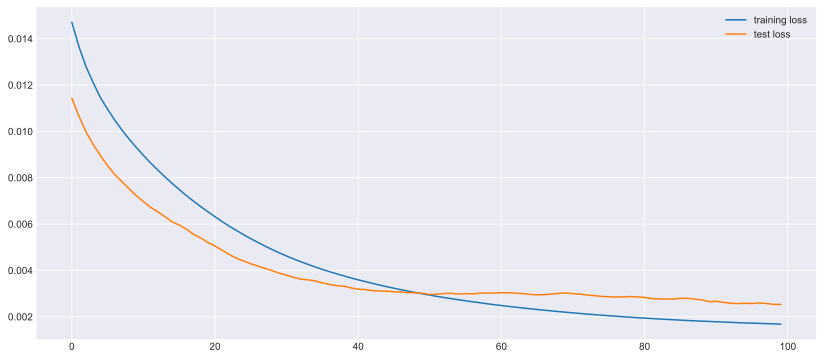

In [63]:
fig, axes = plt.subplots(figsize = (14,6))

axes.plot(result_mo.history['loss'], label = 'training loss')
axes.plot(result_mo.history['val_loss'], label = 'test loss')

axes.grid()
axes.legend()

In [64]:
# get predictions 

pred_train_mo = mo_model.predict(X_train_m)

pred_test_mo = mo_model.predict(X_test_m)

pred_train_mo.shape, pred_test_mo.shape

1/1 [==============================] - 0s 21ms/step


((121, 12), (1, 12))

In [67]:
pred_test_mo

array([[ 0.03267164, -0.00186795,  0.1364173 , -0.01694592,  0.04953331,
         0.15073623,  0.10534723, -0.0124006 , -0.17422965, -0.15687683,
        -0.1248028 ,  0.1205844 ]], dtype=float32)

In [68]:
# indexing predictions, for the train set we will treat them as one step prediction and simply grab the first column 
# we can do so as we use 1,...10, to predict 11,...,22 and then use 2,...,11 to predict, 12,...,23 rd vals and so on
# so the 0th column of each row corresponds to one step prediction for the training set 
# this is a valid approach because the predictions closer to the current time would be expected to be more accurate 

pred_train = pred_train_mo[:,0]

pred_test = pred_test_mo[0]

In [69]:
# save multi-output forecasts 

df.loc[test_idx, 'mo_test_pred'] = last_train + np.cumsum(pred_test)

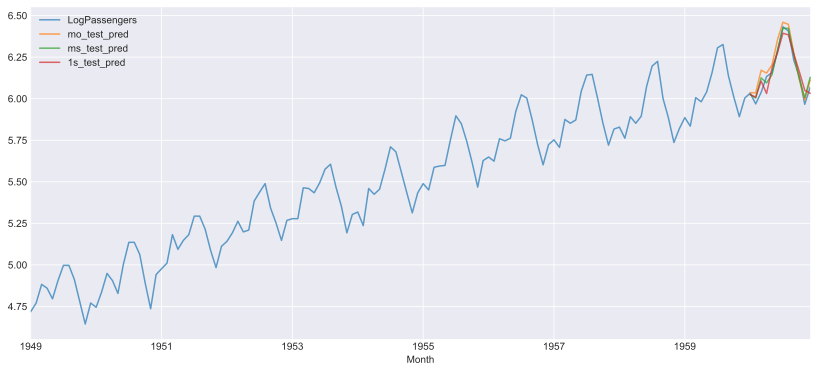

In [71]:
# And plot 

fig, axes = plt.subplots(figsize = (14,6))
cols = ['LogPassengers', 'mo_test_pred', 'ms_test_pred', '1s_test_pred']

df[cols].plot(ax = axes, alpha = 0.7)

axes.grid()



Multi-output forecast method seems to perform worse than incremental multi-step method!

In [74]:
# lets compare their MAPEs

test_lpass = df.iloc[-Ntest:]['LogPassengers']

mape_ms = mean_absolute_percentage_error(test_lpass, df.loc[test_idx, 'ms_test_pred'])
mape_mo = mean_absolute_percentage_error(test_lpass, df.loc[test_idx, 'mo_test_pred'])

print(f'Multi-step method MAPE: {mape_ms:.3f}\n',f"Multi-output method MAPE: {mape_mo:.3f}")

Multi-step method MAPE: 0.005
 Multi-output method MAPE: 0.007


Further checks and improvements that can be implemented: 

- Try without differencing and logging 
- More past lags to consider? 
- Walk forward valdiation to optimize the hyperparameters

